In [1]:
# For boba

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"

import torch
print(torch.cuda.device_count())

2


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# model_name = "meta-llama/Llama-2-7b-chat-hf"
model_name = "HuggingFaceTB/SmolLM-1.7B-Instruct"

model = AutoModelForCausalLM.from_pretrained(model_name,torch_dtype=torch.float16, attn_implementation='sdpa', device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')

/home/vijay/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/vijay/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
import transformers
print(transformers.__version__)

4.37.2


In [4]:
padding_window = 64
query_window = 24
max_tokens = 512

In [5]:
from typing import Optional, Tuple
from transformers.cache_utils import Cache
from transformers.models.llama.modeling_llama import apply_rotary_pos_emb, repeat_kv
import math
from torch import nn
import torch.nn.functional as F

def sdpa_forward(
    self,
    hidden_states: torch.Tensor,
    attention_mask: Optional[torch.Tensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    past_key_value: Optional[Cache] = None,
    output_attentions: bool = False,
    use_cache: bool = False,
) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
    # print("Running custom forward function")
    bsz, q_len, _ = hidden_states.size()

    query_states = self.q_proj(hidden_states)
    key_states = self.k_proj(hidden_states)
    value_states = self.v_proj(hidden_states)

    query_states = query_states.view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
    key_states = key_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
    value_states = value_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)

    kv_seq_len = key_states.shape[-2]
    if past_key_value is not None:
        kv_seq_len += past_key_value.get_usable_length(kv_seq_len, self.layer_idx)
    cos, sin = self.rotary_emb(value_states, seq_len=kv_seq_len)

    query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin, position_ids)

    if past_key_value is not None:
        cache_kwargs = {"sin": sin, "cos": cos}  # Specific to RoPE models
        key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)

    key_states = repeat_kv(key_states, self.num_key_value_groups)
    value_states = repeat_kv(value_states, self.num_key_value_groups)

    if attention_mask is not None:
        if attention_mask.size() != (bsz, 1, q_len, kv_seq_len):
            raise ValueError(
                f"Attention mask should be of size {(bsz, 1, q_len, kv_seq_len)}, but is {attention_mask.size()}"
            )

    # SDPA with memory-efficient backend is currently (torch==2.1.2) bugged with non-contiguous inputs with custom attn_mask,
    # Reference: https://github.com/pytorch/pytorch/issues/112577.
    if query_states.device.type == "cuda" and attention_mask is not None:
        query_states = query_states.contiguous()
        key_states = key_states.contiguous()
        value_states = value_states.contiguous()

    # multiply q by k and and return it back to the user.
    attn_weights = torch.matmul(query_states[..., -query_window:, :], key_states.transpose(2, 3)) / math.sqrt(self.head_dim)
    mask = torch.full((query_window, query_window), torch.finfo(attn_weights.dtype).min, device=attn_weights.device)
    mask_cond = torch.arange(mask.size(-1), device=attn_weights.device)
    mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 0)
    mask = mask.to(attn_weights.device)
    weights_attention_mask = mask[None, None, :, :]
    attn_weights[:, :, -query_window:, -query_window:] += weights_attention_mask

    attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)
    attn_weights_sum = attn_weights[:, :, -query_window:, : -query_window].sum(dim = -2)
    attn_cache = F.avg_pool1d(attn_weights_sum, kernel_size = 7, padding=7//2, stride=1)

    attn_output = torch.nn.functional.scaled_dot_product_attention(
        query_states,
        key_states,
        value_states,
        attn_mask=attention_mask,
        dropout_p=self.attention_dropout if self.training else 0.0,
        # The q_len > 1 is necessary to match with AttentionMaskConverter.to_causal_4d that does not create a causal mask in case q_len == 1.
        is_causal=self.is_causal and attention_mask is None and q_len > 1,
    )

    attn_output = attn_output.transpose(1, 2).contiguous()
    attn_output = attn_output.reshape(bsz, q_len, self.hidden_size)

    attn_output = self.o_proj(attn_output)

    return attn_output, attn_cache, past_key_value

for i in range(len(model.model.layers)):
    model.model.layers[i].self_attn.forward = sdpa_forward.__get__(model.model.layers[i].self_attn, type(model.model.layers[i].self_attn))

In [6]:
import re
def chunk_text_naturally(text, max_chunk_size=4000):
    # Regular expression to find suitable breakpoints (spaces, punctuation, paragraph breaks)
    delimiter_pattern = re.compile(r'(?<=\s)|(?<=[.,!?;:])|(?<=\n\n)')

    # Initialize variables
    chunks = []
    start_idx = 0

    while start_idx < len(text):
        # Find the end index for the current chunk
        end_idx = start_idx + max_chunk_size
        
        # If the end index is beyond the text length, adjust it to the text's end
        if end_idx >= len(text):
            chunks.append(text[start_idx:])
            break

        # Search for the nearest natural delimiter within the chunk size limit
        match = list(delimiter_pattern.finditer(text, start_idx, end_idx))
        
        if match:
            # Find the last delimiter within the range to split the text
            split_idx = match[-1].end()
        else:
            # If no natural delimiter found, split at the max chunk size
            split_idx = end_idx

        # Append the chunk and move to the next start index
        chunks.append(text[start_idx:split_idx].strip())
        start_idx = split_idx

    return chunks

In [7]:
sample_text = open("snapkv_full.txt", "r", encoding="utf-8").read()
encoded_tokens = tokenizer(sample_text, return_tensors="pt")
for key in encoded_tokens:
    encoded_tokens[key] = encoded_tokens[key].cuda()
encoded_tokens = encoded_tokens.input_ids[0]
print(encoded_tokens.shape)

Token indices sequence length is longer than the specified maximum sequence length for this model (17256 > 2048). Running this sequence through the model will result in indexing errors


torch.Size([17256])


Query tokens:   approaches on managing the challenges of large-scale language modeling.

What is the GitHub repository for SnapKV?
Unpadded chunks length:  2
Unpadded chunks length:  4
Unpadded chunks length:  7
Unpadded chunks length:  9
Unpadded chunks length:  11
Unpadded chunks length:  13
Unpadded chunks length:  15
Unpadded chunks length:  19
Unpadded chunks length:  25
Unpadded chunks length:  31
Unpadded chunks length:  35
Unpadded chunks length:  37
Unpadded chunks length:  39
Unpadded chunks length:  41
Unpadded chunks start:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
First length:  24
Second length:  41
Third length:  torch.Size([32, 581])
Shape:  torch.Size([24, 41, 32, 581])
Shape:  torch.Size([41, 32, 581])
Shape:  torch.Size([41, 32, 581])
Score:  7640.0
<|im_start|>user
 the KV caches during the generation. This limitation implies that \kv cannot extend a model's long context capability if

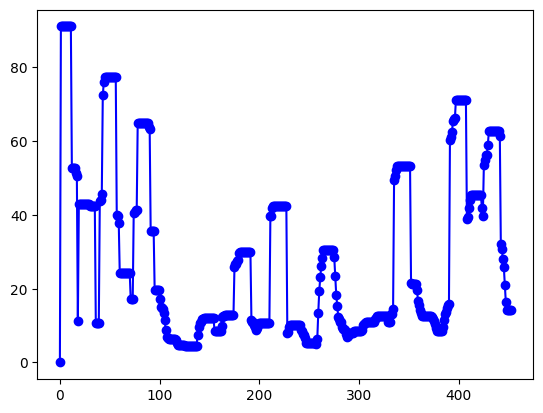

Score:  7156.0
<|im_start|>user
it{LLMs knows what you are looking for before generation}.
    \item We develop an efficient algorithm, \kv, inspired and validated by extensive observations and testing. \kv intelligently identifies important KVs with minimal modification (See Fig.~\ref{fig: algo}). The algorithm can be easily integrated into popular deep-learning frameworks with just a few code adjustments.

    \item We evaluate \kv for accuracy and efficiency\begin{figure}[ht]
    \centering\includegraphics[width=0.65\textwidth]{figures/illustration.pdf}
        \caption{The graph shows the simplified workflow of \kv, where the orange area represents the group of positions per head clustered and selected by \kv. These clustered features are then used to form a new Key-Value pair concatenated with the tokens in the observation window (denoted as `Window'). Together, the selected prefix and observation windows constitute the new KV cache utilized for the generation. 
    }
    \label{f

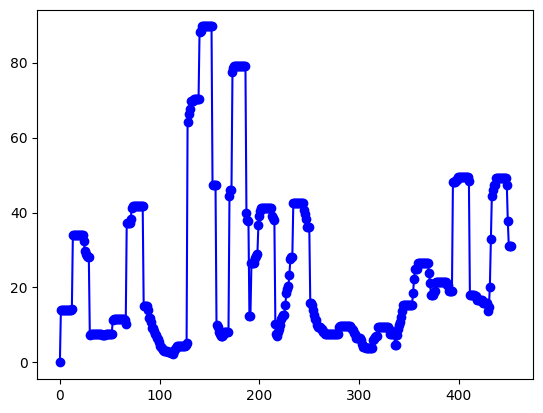

Score:  7068.0
<|im_start|>user
Pattern consistency across contexts:} Irrespective of the generation context length, we observed that specific keys within the prompt consistently exhibit higher attention weights. Such ``active'' keys tend to follow stable patterns that appear to be intrinsically related to the structure and content of the prompt. (Sec.~\ref{sec: Multi-Turn Conversations})

\item \textbf{Invariance to question positions in summarization tasks:}across diverse LLMs and long-sequence datasets, affirming its improvement over previous work and comparability to conventional KV caching. Furthermore, we conduct the Needle-in-a-Haystack test to demonstrate its memory efficiency and illustrate decoding speed enhancements through varied batch sizes and input lengths. In addition, \kv's integration with a leading RAG model showcases its extended performance capabilities. We also show that \kv can be combined orthogonally with other acceleration strategies such as parallel decoding.

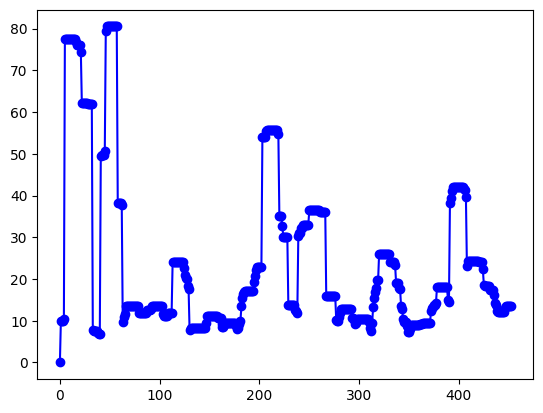

Score:  7024.0
<|im_start|>user
-Pro-1.5 with 1M~\cite{reid2024gemini}. Despite their impressive capabilities, LLMs still face significant challenges when dealing with long context inputs. Specifically, the KV caches in attention calculation become an obstacle in efficiently processing long context. During inference time, as input length increases, the decoding speed per step grows linearly due to the computation for attention across past KVs. Moreover, the large KV cache created during prompting requires significant on-chip and off-chip memory, increasing hardware demands and limiting model scalability.

There are many perspectives to mitigate these problems, including KV cache eviction during token generation~\cite{xiao2023efficient, zhang2024h2o, liu2024scissorhands, ge2023model}. However, most of these methods lack a detailed evaluation of the generated context in a long-context setting. Moreover, they mainly focus on optimizing the KV cache appended during generation steps, while 

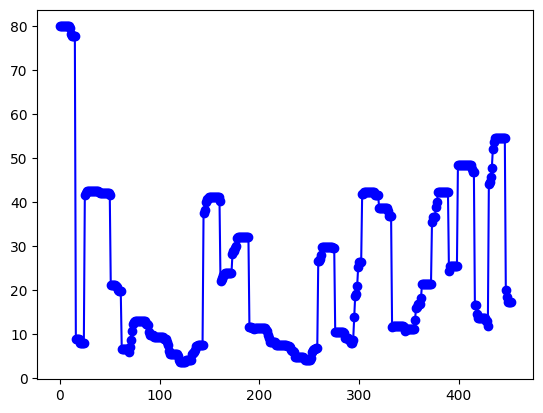

Score:  6876.0
<|im_start|>user
Mistral-7B-Instruct-v0.2_nopool.pdf}
    \includegraphics[width=0.9\textwidth]{figures/Mistral-7B-Instruct-v0.2_maxpool.pdf}
    \caption{Ablation study of pooling on LongEval-Lines. The evaluation includes inputs, each comprised of lines formatted as~\url{https://github.com/FasterDecoding/SnapKV}.
\end{abstract}
\section{Introduction}

\subsubsection{Needle-in-a-Haystack} 
The Needle-in-a-Haystack test \cite{kamradt2023needle} challenges the model to accurately retrieve information from a specific sentence("needle") hidden within a lengthy document (the "haystack"), with the sentence placed at a random location. To rigorously evaluate \kv's capabilities, we extended the document length to 380k tokens which is the longest content that can be processed by a single A100-80GB GPU. We configured the prompt KV cache size to 1024, enabling \kv to select the most crucial 1024 attention features from the prompt using our algorithm for answer generation, with a m

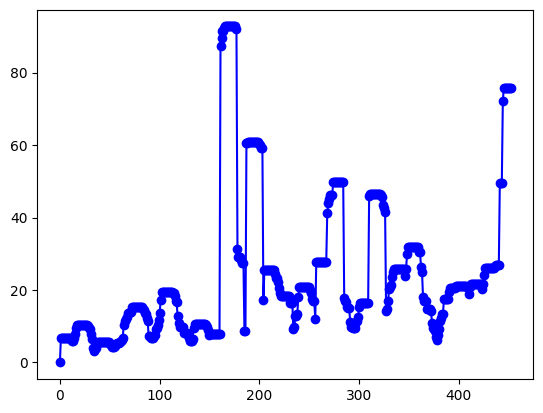

Score:  6868.0
<|im_start|>user
 indices.unsqueeze(-1).expand(-1, -1, -1, head_dim)
        # Gather the compressed past key and value states based on the selected indices.
        k_past_compress = key_states[..., :-window_size, :].gather(dim=2, index=indices)
        v_past_compress = value_states[..., :-window_size, :].gather(dim=2,features selected by different instruction-response pairs within the same document by using \(\mathcal{H}(\text{M}_{\text{vote\_A}}, \text{M}_{\text{vote\_B}})\). By varying the instructions, we observe that different instructions prioritize different prefix keys, as indicated by the descending trend in hit rates shown in Fig. \ref{fig: qa_pairs}. 
Our findings reveal an interesting aspect of KV cache management in LLMs: the important attention features change with different instructions. This variability challenges the effectiveness of static compression methods that depend on constant weighted importance or fixed policies~\cite{liu2024scissorhands,zhang

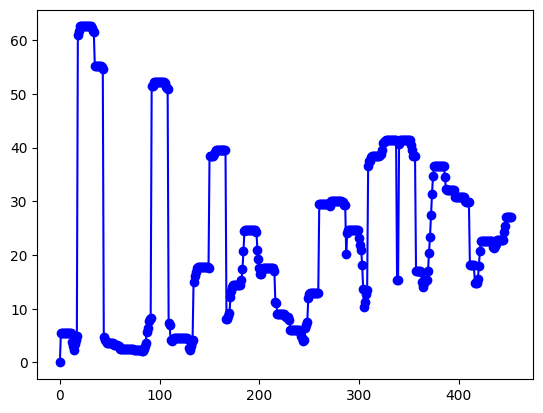

Score:  6610.0
<|im_start|>user
 \textbf{19.84}&\cellcolor{green!10} 10.77 &\cellcolor{green!10} 19.79 & \cellcolor{green!10}24.44 &\cellcolor{green!10} 23.53 &\cellcolor{green!10} 70.0"\texttt{line makeshift-penguin: REGISTER\_CONTENT is <10536>}", where the key is an adjective-noun pair and the value is a random 5-digit number. The model needs to retrieve the value based on a given key. 
    The x-axis denotes the length of the input; the y-axis indicates the position of the groundtruth, from 5K to 30K tokens. With the pooling, the model can retrieve correct values before 16k and performs significantly better than the one without pooling.
    }
    \label{fig: ablation}
\end{figure}
We perform an ablation study to assess the impact of our pooling technique, a straightforward but efficient method for consolidating information through clustering. Our evaluation utilizes the modified LongEval-Lines benchmark~\cite{longchat2023}, incorporating random generated pairs and averaged scores. 

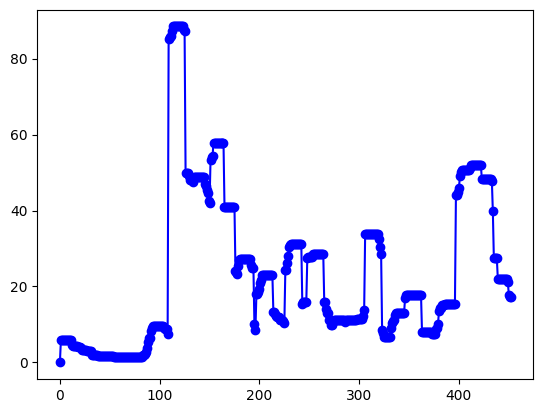

Score:  6532.0
<|im_start|>user
, it maintains comparable performance to baseline models across 16 long sequence datasets. Moreover, \kv can process up to 380K context tokens on a single A100-80GB GPU using HuggingFace implementation with minor changes, exhibiting only a negligible accuracy drop in the Needle-in-a-Haystack test. Further comprehensive studies suggest \kv's potential for practical applications. Our code is available atindex=indices)
        k_obs = key_states[..., -window_size:, :]
        v_obs = value_states[..., -window_size:, :]
        key_states = torch.cat([k_past_compress, k_obs], dim=2)
        value_states = torch.cat([v_past_compress, v_obs], dim=2)
        return key_states, value_states
\end{lstlisting}


\subsection{Efficient Clustering via Pooling}
\label{sec: clustering}
In LLMs, information retrieval and generation rely on features with high attention weight and are supplemented by copying the rest in context using induction heads~\cite{olsson2022context

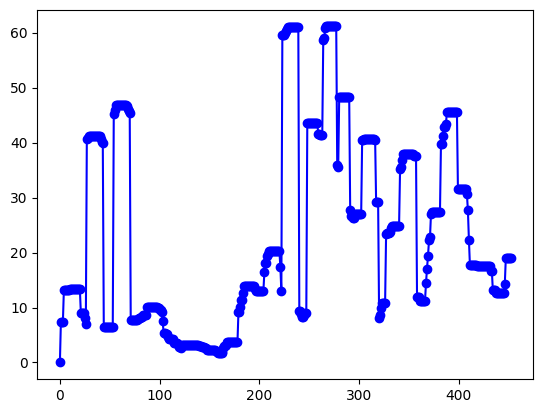

Score:  6500.0
<|im_start|>user
width]{figures/speed_vs_prompt_length.pdf}
    \caption{Comparison of generation speed (ms/token). The baseline is the Huggingface implementation of naive decoding.}
    \label{fig: medusa}
\end{figure}
\subsection{Case Study: Compatibility with Parallel Decoding}

In this section, we provide a novel perspective on employing KV cache\texttt{Command-R} on lost-in-the-middle and generation quality. Lost-in-the-middle is aimed to analyze whether the performance of the model varies when altering the position of ground-truth information in the context \cite{lostinthemiddle}. The latter is a relatively simple metric where we define the accuracy of the model to be the proportion of the ground-truth answer phrase appearing in model's response. We conducted 3 experiments with 30, 100 and 200 sampled documents for each ground-truth. We repeat each experiment 3 times and insert the relevant documents at beginning, middle and end of the context to test \kv's robustn

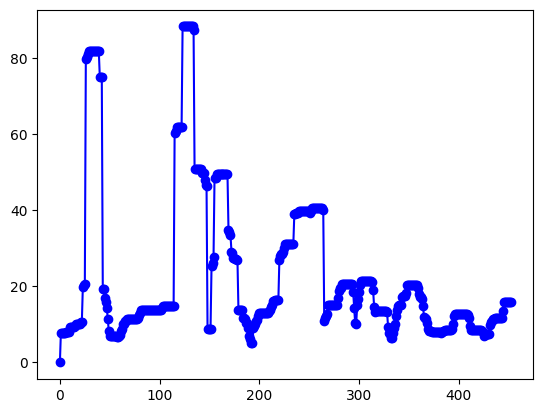

Score:  6348.0
<|im_start|>user
1.2\% \\
RAG End-to-end & F1 score & -2.1\% \\
\bottomrule
\end{tabular}
\label{table:commandr_cite}
\end{table}
\paragraph{Generation} \label{Generation_Section}
As the quality of generation is important to a model's RAG capability, we evaluaterequiring long context, such as retrieval-augmented generation (RAG). We extensively test \texttt{Command-R} on NarrativeQA and a modified version of the Needle-in-a-Haystack where it achieves promising results. To evaluate \kv's impact on RAG, we ran tests on bioasq \cite{bioasq}, multi-hop question answering with HotpotQA \cite{yang2018hotpotqa}, and an internal benchmark on tool use, which further demonstrated its effectiveness. Throughout all experiments, we limit the KV cache to a maximum of 4096 tokens, while the pooling kernel size and window size are set to 13 and 64, respectively. For our evaluations, these hyper-parameters give a KV cache compression ratio between 2x to 32x depending on the sequence leng

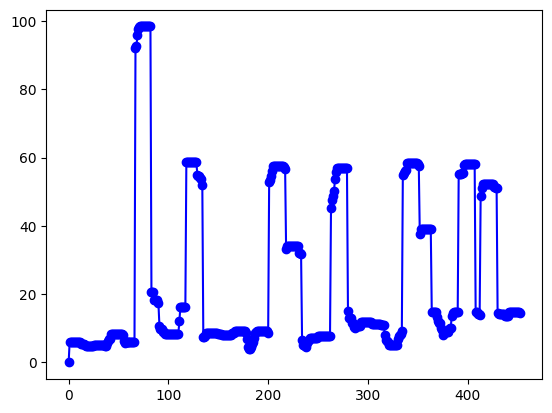

Score:  6184.0
<|im_start|>user
Another perspective is to compress the KV cache for generation steps. Heavy-Hitter Oracle \cite{zhang2024h2o} introduces a KV cache eviction policy that greedily selects tokens during generation steps based on a scoring function derived from cumulative attention. While this approach effectively compresses the KV cache for generated tokens, it overlooks compression of the input sequence KV cache, which is crucial for reducing memory and computational overhead.
Building on a similar concept, Adaptive KV Compression (FastGen) \cite{ge2023model} implements a dual-phase algorithm that encompasses four KV cache compression policies. Initially, it identifies optimal policies through profiling results obtained from prompt encoding. Subsequently, it dynamically evicts caches during the generation phase based on these policies. Nonetheless, it faces the similar problem with H2O. ScissorHands \cite{liu2024scissorhands} focuses on identifying and retaining pivotal t

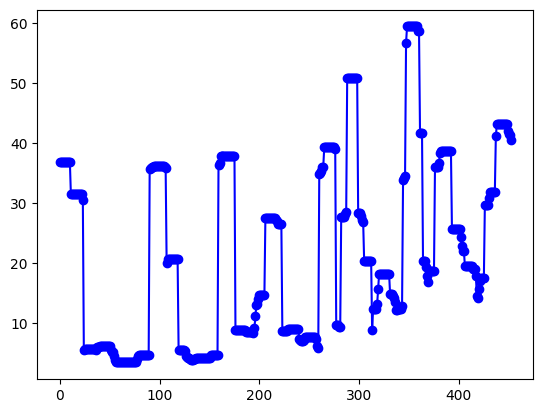

Score:  6076.0
<|im_start|>user
sec:ablation}).  Such sparse selection risks compromising the contextual integrity encapsulated in between features, thereby reducing accuracy. Based on the insights, We propose a fine-grained clustering algorithm utilizing a pooling layer shown in Line \ref{line:pooling}.
\section{Experiments}
In our experimental setup, we explore the performance of \kv across models that can handle extended sequence contexts. First, we deliver a pressure test and benchmark the speed of \texttt{LWM-Text-Chat-1M}~\cite{liu2024world}, which is state-of-the-art regarding its context length.
We then conduct an ablation study on \texttt{Mistral-7B-Instruct-v0.2} to understand the influence of pooling on the model's information retrieval performance. We assess model performances using the LongBench~\cite{bai2023longbench} dataset. Further, we dive into a comprehensive examination of the \texttt{Command-R}~\cite{coherecommandr} model, another leading open-source model in the f

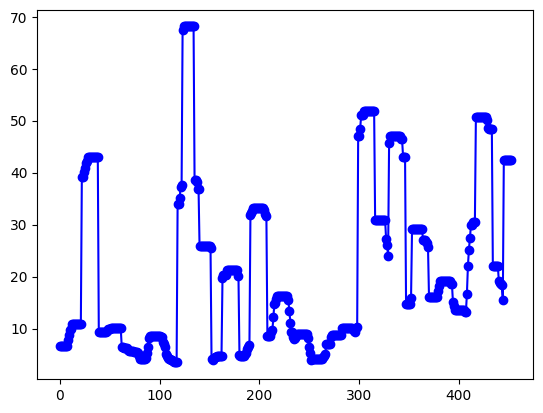

Score:  6004.0
<|im_start|>user
 that utilizes multiple classifiers and tree attention mechanisms for drafting tokens, subsequently verified by LLMs. One of the challenges identified is the issue of speculative decoding in processing long sequences since generating multiple tokens per decoding step introduces computational bottlenecks during long sequence processing, such as query-key matrix multiplication tiling~\cite{dao2023flash}. By maintaining a constant size for the KV cache associated with prompts during generation, \kv enhances generation efficiency.

Empirical results shown in Figure~\ref{fig: medusa} highlight the performance across various prompt lengths, with \texttt{Mistral-7B-Instruct-v0.2}\footnote{\href{https://huggingface.co/text-generation-inference/Mistral-7B-Instruct-v0.2-medusa/tree/main}{TGI trained \texttt{Medusa} heads}} undergoing a maximum of 128 generation steps unless preemptively halted. The experiments utilized a subset of the QASPER~\cite{dasigi2021datase

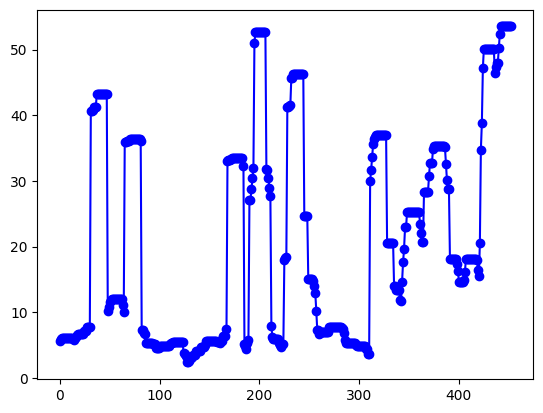

Score:  5988.0
<|im_start|>user
 values are tensors containing information from the previous context. The linear growth in prompts will lead to exponential time complexity for generation due to the Query-Key matrix multiplication. \kv addresses this by keeping prompt KV cache counts constant during generation, significantly reducing serving times for long-context LLMs.

The fundamental approach of \kv involves identifying and selecting the most crucial attention features per head to create the new KV cache. \kv operates through two stages as shown in Fig.~\ref{fig: algo}:
\begin{itemize}[leftmargin=*]
    \item \textbf{Voting for Important Previous Features}
    By the voting process defined previously (Eq.~\ref{eq: length}), we select the important features based on the observation window—defined as the last segment of the prompt. Sec.~\ref{sec: Multi-Turn Conversations} highlights the consistency of these attention features throughout the sequence, suggesting that these features are 

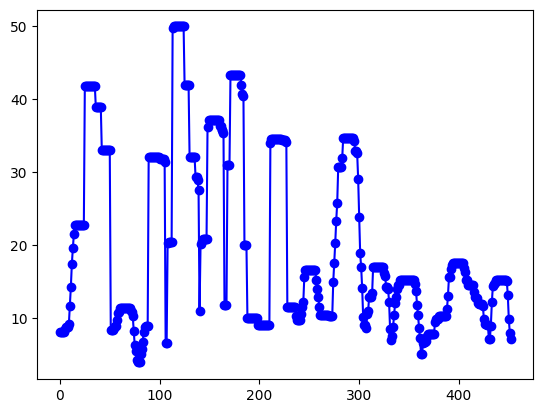

Score:  5876.0
<|im_start|>user
 \cite{kamradt2023needle} evaluation was heavily influenced by the specific context used. To address this issue, we modify the evaluation by permuting context compositions for each length and depth combination. This approach, which we ran eight times, yielded more robust results. We observe a slight decrease in scores across all models tested under this setting compared to the original setup with no context shuffling. For simplicity, we aggregated the scores across all depths and lengths for the baseline model and the one with \kv. As seen in Table \ref{table:commandr_needles}, applying \kv to \texttt{Command-R} shows no degradation in performance, even with a 128k sequence length resulting in 32x compression of KV cache.

\begin{table}[h]
\centering
\caption{Needles-in-a-Haystack Test Results}
\begin{tabular}{lccc}
\toprule
\text{Model} & \texttt{Command-R} & \texttt{Command-R} + \kv & \text{\% Difference} \\
\midrule
Score & 9.866 & 9.819 & -0.5\% \\
\

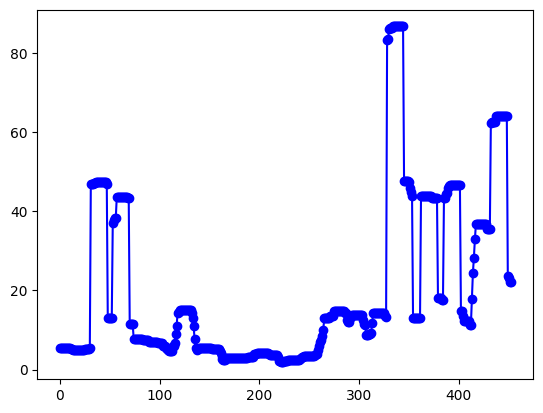

Score:  5836.0
<|im_start|>user
-a-Haystack test underscore \kv's potential to precisely manage small details on extremely long input contexts with a 380x compression ratio. 
\begin{figure}[ht]
    \centering
        \includegraphics[width=0.9\textwidth]{figures/LWM-Text-Chat-1M_compress.pdf}
    \caption{Needle-in-a-Haystack test performance comparison on single A100-80GB GPU, native HuggingFace implementation with only a few lines of code changed. The x-axis denotes the length of the document (the “haystack”); the y-axis indicates the position that the “needle” (a short sentence) is located within the document, from 1K to 380K tokens. For example, 50\% indicates that the needle is placed in the middle of the document. Here LWMChat with \kv is able to retrieve the needle correctly before 160k and with only a little accuracy drop after. Meanwhile, the original implementation encounters OOM error with 33k input tokens.
    }
    \label{fig: needle}
\end{figure}
\begin{figure}[ht]
    \c

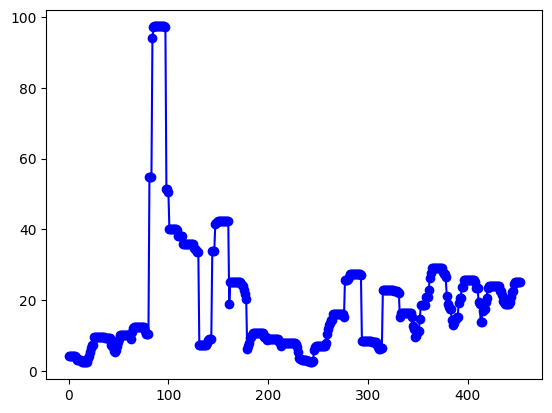

Score:  5828.0
<|im_start|>user
 template used in the table.
\end{tablenotes}
\end{threeparttable}\vspace{-10pt}

\end{table*}

\subsection{Experiments on LongBench}
We evaluate \kv on these four models using LongBench~\cite{bai2023longbench}, a multi-task benchmark designed to rigorously evaluate long context understanding capabilities across various datasets, spanning single and multi-document QA, summarization, few-shot learning, synthetic tasks, and code completion. We choose \texttt{LWM-Text-Chat-1M} with 1 million context length, \texttt{LongChat-7b-v1.5-32k}, \texttt{Mistral-7B-Instruct-v0.2}, \texttt{Mixtral-8x7B-Instruct-v0.1} with 32k context length as our baselines. For each model, we test \kv with various settings: compressing KV caches in the prompt to 1024, 2048, and 4096 tokens. We use max pooling with kernel size 7 and observation window size 32. Table \ref{tab:longbench} illustrates a negligible performance drop from models with \kv compared with original implementatio

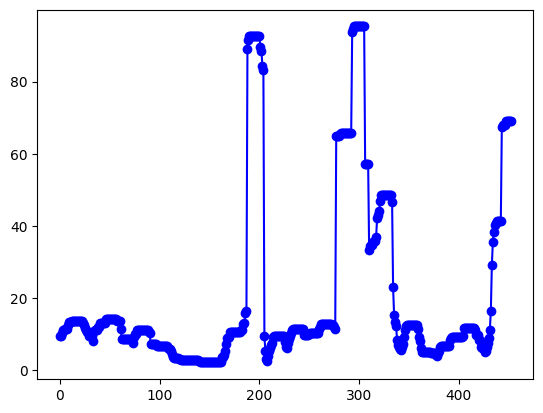

Score:  5750.0
<|im_start|>user
\text{prefix}}\)\textbf{):} The length of the input preceding the observation window. It is part of the prompt and does not include the observation window.
\textbf{Observation Window (}\(L_{\text{obs}}\)\textbf{):} The last segment of the prompt. This window is crucial for analyzing the influence of different contexts on attention patterns.
These definitions are interconnected as follows:
\begin{equation}\label{eq: length}
L_{\text{prompt}} = L_{\text{prefix}} + L_{\text{obs}}
\end{equation}
\textbf{Voting:} The process of calculating attention weights for each query within the observation window across all heads, aggregating these weights to highlight the prefix positions that are considered most significant.

For a single batch of sequence, formally:
\begin{align}
\mathbf{C} &= \sum_{i=0}^{L_{\text{obs}}} \mathbf{W}_{\text{obs}}[:, i, :] \\
I &= \text{Top}_k(\mathbf{C}, k)
\end{align}

where \(\text{Top}_k(\mathbf{T}, k)\) selects the indices of the to

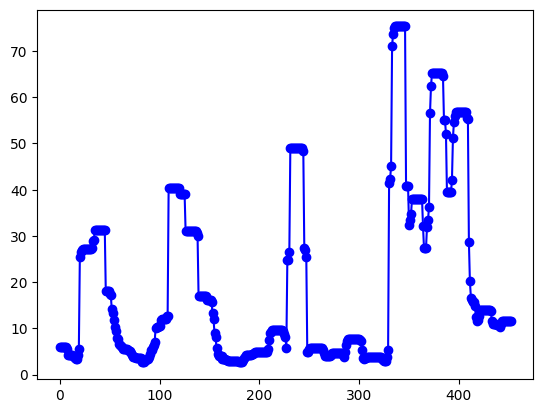

Score:  5696.0
<|im_start|>user
 features within the context. We can use \(\mathcal{H}(\mathbf{M}_{\text{threshold\_cur}}, \mathbf{M}_{\text{vote\_obs}})\) denote combination of eq.~\ref{eq:stepa} and eq.~\ref{eq:stepb}. We use $p = 0.05$ (top 5\% location perIn the context of long summarization and question-answering tasks, the positioning of questions within the prompt (either at the beginning or the end) does not significantly alter the consistency of attention patterns observed. This suggests a level of robustness in how we can obtain the attention of relevant features trivially, regardless of the position of questions. (Sec.~\ref{sec: Do Question Positions Matter?})

\item \textbf{Contextual dependency of patterns:} The observed attention patterns are highly context-sensitive, indicating a strong association with the specific instructions posed by the user (Sec.~\ref{sec: Do Different Questions Matter for One Document?}). Thus, a context-aware KV compression approach can potential

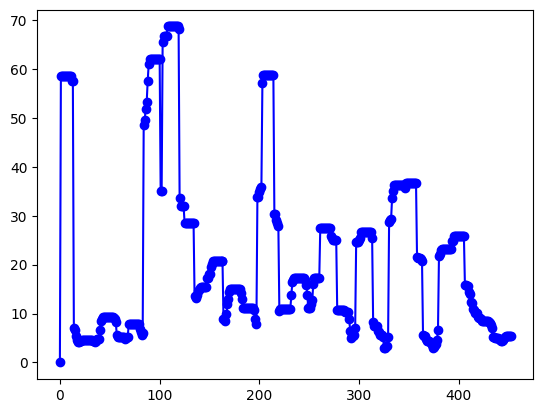

Score:  5444.0
<|im_start|>user
textwidth]{figures/hit_rate_3k.pdf}
    \caption{
    The layer-wise average hit rate of important positions utilized along token generation with an average input length exceeding 3k.
    }
    \label{fig: hit_rate}
\end{figure}

\begin{figure}[ht]
    \centering
    \includegraphics[width=0.7\textwidth]{figures/question_front.pdf}
    \includegraphics[width=0.7\textwidth]{figures/question_back.pdf}
    \caption{The layer-wise average hit rate of important positions utilized by prompts with questions at the beginning and the end.}
    \label{fig: question_pos}
\end{figure}

This study examines if the positions of features identified as crucial in the observation window maintain their significance in the subsequent token generation. The analysis utilizes samples from Ultrachat~\cite{ding2023enhancing}, a multi-turns, high-quality instruction dataset consisting of 1.4 million dialogues. We further filter the sequences with response length greater than 512 

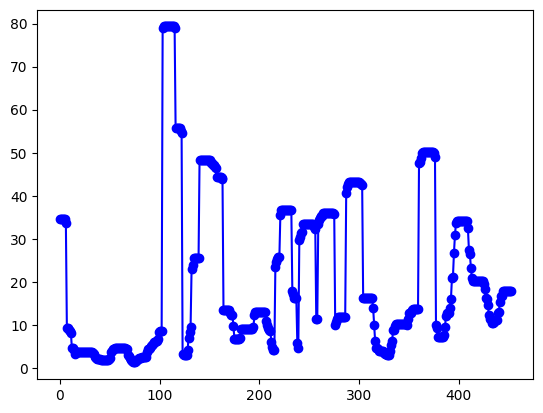

Score:  5224.0
<|im_start|>user
section{Effectiveness of Various Instructions for One Document}
\label{sec: Do Different Questions Matter for One Document?}

Furthermore, we investigate whether instructions will affect the selection of important features even if the provided context is the same. Our experiment utilizes different instructions on the same document and selects the important features based on the observation window that consists of both the instructions and their corresponding responses. Then we calculate the hit rates between importanthead) and $\theta = 0.05$ (note it is a large value due to the softmax function over a long sequence) for the observation experiments. The model we probe is \texttt{Mistral-7B-Instruct-v0.2}.






\subsection{Observations in Multi-Turn Conversations}
\label{sec: Multi-Turn Conversations}

\begin{figure}[ht]
    \centering
    % \includegraphics[scale = 0.2]{figures/hit_rate_1k.png}
    % \includegraphics[scale = 0.2]{figures/hit_rate_1.5k.p

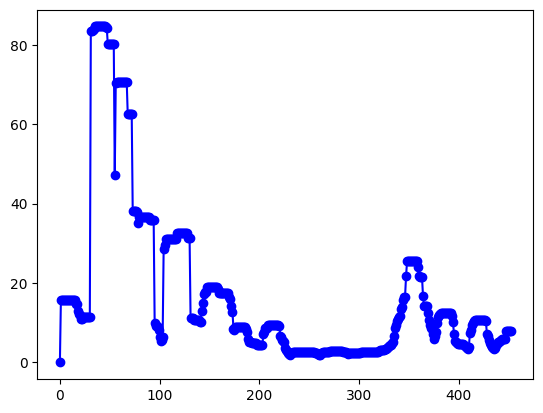

Score:  4544.0
<|im_start|>user
generation}
\begin{tabular}{@{}cccc@{}}
\toprule
Number of Documents & Approximate Context Length & Ground Truth Position & \% Difference \\ \midrule
\multirow{4}{*}{30}  & \multirow{4}{*}{8k}  & 0  & -1.8\% \\
                     &                      & 14 & 0\%   \\
                     &                      & 30 & -3.4\% \\
                     &                      & Avg & -1.7\% \\ \midrule
\multirow{4}{*}{100} & \multirow{4}{*}{14k} & 0  & -1.2\% \\
                     &                      & 14 & +0.9\% \\
                     &                      & 30 & -0.9\% \\
                     &                      & Avg & -0.6\% \\ \midrule
\multirow{4}{*}{200} & \multirow{4}{*}{24k} & 0  & +4.9\% \\
                     &                      & 14 & +4.9\% \\
                     &                      & 30 & +6.4\% \\
                     &                      & Avg & +5.4\% \\ \bottomrule
\end{tabular}
\smallskip
\small
\textit{Note:} For eac

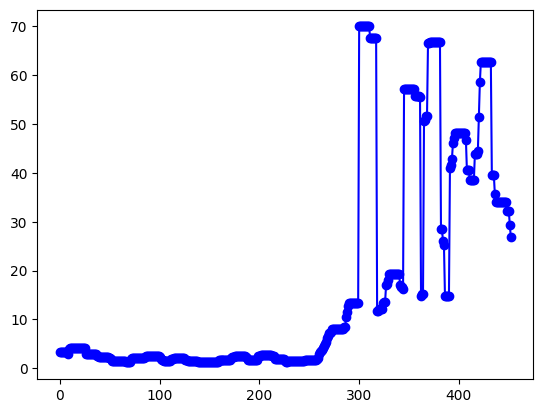

Score:  4470.0
<|im_start|>user
in-a-Haystack, the relevant information is more distinctly separated from other contexts. We apply max pooling with a kernel size of 5 and use the observation window with a size of 16. The findings, illustrated in our results (Fig.~\ref{fig: ablation}), indicate that pooling significantly enhances retrieval accuracy compared to methods not utilizing pooling. We hypothesize that this is due to the ability of strong attention mechanisms to focus on the initial portion of tokens. Without information compression, large language models tend to replicate the subsequent tokens, leading to retrieved partially correct results when the KV cache is compressed as we observed. Note that throughout our experiments, the choice between max pooling and average pooling did not yield significant differences in performance.
\begin{table*}[t]

\fontsize{18}{24}\selectfont
\setlength{\tabcolsep}{5pt}
\centering
\caption{Performance comparison of \kv and H2O across various LLM

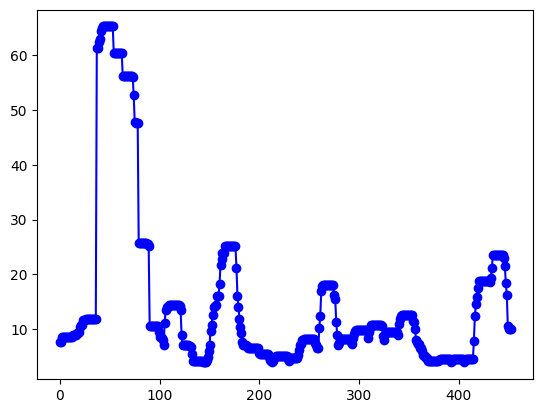

Score:  4210.0
<|im_start|>user
{obs}} \times L_{\text{prefix}}}\) represents the subset of the prompt softmax-normalized attention features over $N$ heads.


\textbf{Hit Rate:} The hit rate, \(H\), quantifies the effectiveness of the voting mechanism by measuring the ratio of attention features identified as significant by the voting process that are also essential in the generation outcome, calculated as:

\begin{align}
\mathbf{M}_{\text{vote\_obs}} &= \text{zeros\_like} (\mathbf{A}_{\text{cur}}) \\
\mathbf{M}_{\text{vote\_obs}}[I] &= 1 \\
\mathbf{M}_{\text{threshold\_cur}} &= \mathbf{1}(\mathbf{A}_{\text{cur}} > \theta) \\
\mathbf{O} &= \mathbf{M}_{\text{threshold\_cur}} \land \mathbf{M}_{\text{vote\_obs}} \label{eq:stepa}\\
H &= \frac{\sum \mathbf{O}}{\sum \mathbf{M}_{\text{threshold\_cur}}} \label{eq:stepb}
\end{align}


\(\mathbf{A}_{\text{cur}}\in \mathbb{R}^{N \times L_{\text{prefix}}}\) represents the attention features between the current generated query and prefix keys. The 

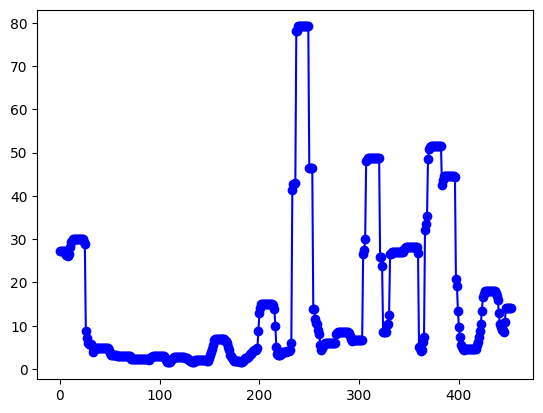

Score:  3508.0
<|im_start|>user

& \cellcolor{cyan!10}~~~H2O: 4096 & \cellcolor{cyan!10}20.45 & \cellcolor{cyan!10}32.09 & \cellcolor{cyan!10}48.02 & \cellcolor{cyan!10}34.76 & \cellcolor{cyan!10}25.69 & \cellcolor{cyan!10}16.5 & \cellcolor{cyan!10}29.76 & \cellcolor{cyan!10}23.53 & \cellcolor{cyan!10}26.84 & \cellcolor{cyan!10}74.5 & \cellcolor{cyan!10}90.24 & \cellcolor{cyan!10}47.1 & \cellcolor{cyan!10}\textbf{7.06} & \cellcolor{cyan!10}99.42 & \cellcolor{cyan!10}64.91 & \cellcolor{cyan!10}63.52 \\



\specialrule{1pt}{2pt}{0pt}



\end{tabular}

}
\begin{tablenotes}
    \scriptsize
    \item[] \hspace{-20pt}\textsuperscript{a} Credit to Jin et al.~\cite{jin2024llm} for the template used in the table.
\end{tablenotes}
\end{threeparttable}\vspace{-10pt}

\end{table*}

\subsection{Experiments on LongBench}
We evaluate \kv on these four models using LongBench~\cite{bai2023longbench}, a multi-task benchmark designed to rigorously evaluate long context understanding capabilities across v

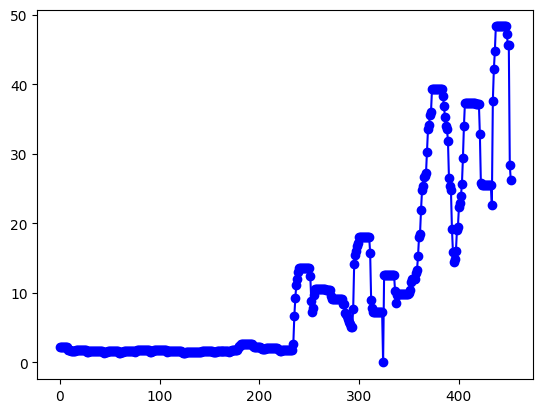

Score:  3392.0
<|im_start|>user
 
\subsection{Experiments on Command-R}
To further assess the performance of \kv, we conduct experiments using Cohere's \texttt{Command-R} model \cite{coherecommandr}, an open-source model with 35B parameters and capable of handling sequences of up to 128k token length. \texttt{Command-R} is designed for complex tasks98 \\

& \cellcolor{cyan!10}~~~\kv: 2048 & \cellcolor{cyan!10}\textbf{27.12} & \cellcolor{cyan!10}36.9 & \cellcolor{cyan!10}51.91 & \cellcolor{cyan!10}47.46 & \cellcolor{cyan!10}33.23 & \cellcolor{cyan!10}26.27 & \cellcolor{cyan!10}30.19 & \cellcolor{cyan!10}25.84 & \cellcolor{cyan!10}27.8 & \cellcolor{cyan!10}\textbf{76.0} & \cellcolor{cyan!10}90.24 & \cellcolor{cyan!10}46.31 & \cellcolor{cyan!10}5.5 & \cellcolor{cyan!10}100.0 & \cellcolor{cyan!10}68.72 & \cellcolor{cyan!10}\textbf{70.01} \\

& \cellcolor{cyan!10}~~~\kv: 4096 & \cellcolor{cyan!10}26.46 & \cellcolor{cyan!10}37.03 & \cellcolor{cyan!10}\textbf{52.62} & \cellcolor{cyan!10}47.71

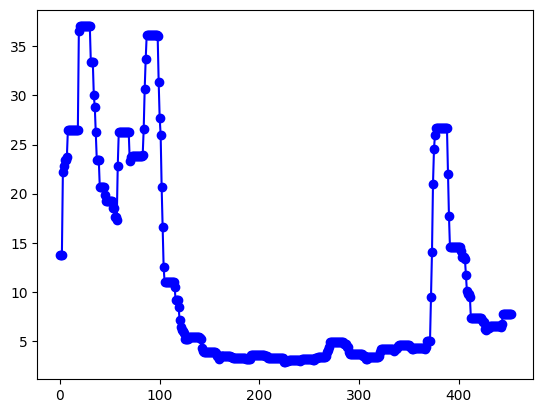

Score:  3014.0
<|im_start|>user
icolumn{2}{c}{Synthetic} & \multicolumn{2}{c}{Code} \\
\cmidrule(lr){3-5}\cmidrule(lr){6-8}\cmidrule(lr){9-11}\cmidrule(lr){12-14}\cmidrule(lr){15-16}\cmidrule(lr){17-18}
&& \rotatebox[origin=c]{30}{NrtvQA} & \rotatebox[origin=c]{30}{Qasper} & \rotatebox[origin=c]{30}{MF-en} & \rotatebox[origin=c]{30}{HotpotQA} & \rotatebox[origin=c]{30}{2WikiMQA} & \rotatebox[origin=c]{30}{Musique} & \rotatebox[origin=c]{30}{GovReport} & \rotatebox[origin=c]{30}{QMSum} & \rotatebox[origin=c]{30}{MultiNews} & \rotatebox[origin=c]{30}{TREC} & \rotatebox[origin=c]{30}{TriviaQA} & \rotatebox[origin=c]{30}{SAMSum} & \rotatebox[origin=c]{30}{PCount} & \rotatebox[origin=c]{30}{PRe} & \rotatebox[origin=c]{30}{Lcc} & \rotatebox[origin=c]{30}{RB-P} \\

\specialrule{1pt}{2pt}{2pt}

\multirow{5}{*}{\rotatebox[origin=c]{90}{\fontsize{18}{100}\selectfont LWMChat}}

&\cellcolor{green!10}~~~All KV & \cellcolor{green!10}\textbf{18.18}&\cellcolor{green!10}\textbf{25.56}&\cellcolor{green!

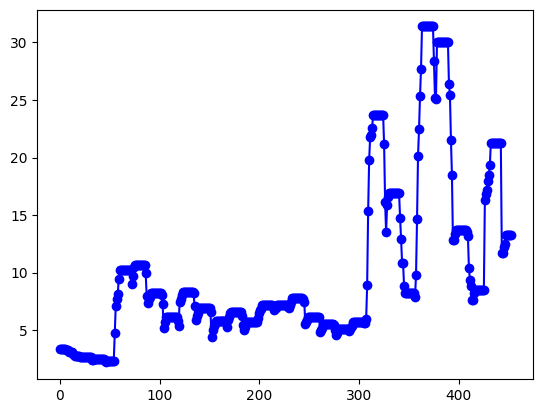

Score:  2766.0
<|im_start|>user
 &\cellcolor{green!10} \textbf{3.17} &\cellcolor{green!10}\textbf{4.0} & \cellcolor{green!10}\textbf{44.49} & \cellcolor{green!10}44.08\\

&\cellcolor{green!10}~~~H2O: 4096 & \cellcolor{green!10}13.17&\cellcolor{green!10}24.82&\cellcolor{green!10}20.01&\cellcolor{green!10} 16.86 &\cellcolor{green!10} 9.74&\cellcolor{green!10} 7.2 &\cellcolor{green!10} 25.77 & \cellcolor{green!10}23.26 &\cellcolor{green!10} 23.83 &\cellcolor{green!10} \textbf{71.0} &\cellcolor{green!10} 61.06 & \cellcolor{green!10} \textbf{40.33} &\cellcolor{green!10} 0.0 &\cellcolor{green!10}0.0 & \cellcolor{green!10}41.52 & \cellcolor{green!10}40.97\\


\specialrule{1pt}{2pt}{10pt}\specialrule{1pt}{2pt}{2pt}

\multirow{5}{*}{\rotatebox[origin=c]{90}{\fontsize{18}{100}\selectfont LongChat}}

& \cellcolor{blue!10}~~~All KV & \cellcolor{blue!10}\textbf{20.88} & \cellcolor{blue!10}\textbf{29.36} & \cellcolor{blue!10}\textbf{43.2} & \cellcolor{blue!10}33.05 & \cellcolor{blue!10}24.58 & \cell

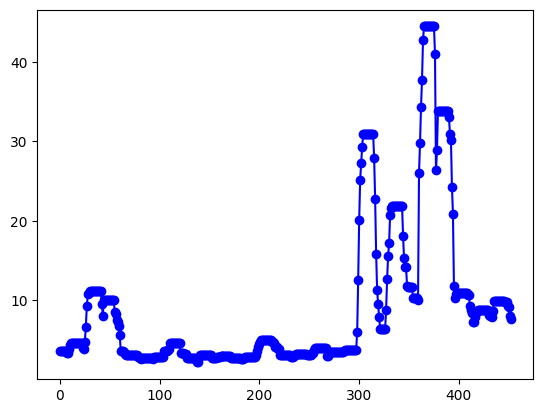

Score:  2666.0
<|im_start|>user
color{cyan!10}90.42 & \cellcolor{cyan!10}46.48 & \cellcolor{cyan!10}5.5 & \cellcolor{cyan!10}99.5 & \cellcolor{cyan!10}69.02 & \cellcolor{cyan!10}68.& \cellcolor{blue!10}23.06 & \cellcolor{blue!10}11.76 & \cellcolor{blue!10}27.55 & \cellcolor{blue!10}21.37 & \cellcolor{blue!10}26.49 & \cellcolor{blue!10}66.0 & \cellcolor{blue!10}75.8 & \cellcolor{blue!10}39.92 & \cellcolor{blue!10}0.0 & \cellcolor{blue!10}25.5 & \cellcolor{blue!10}53.56 & \cellcolor{blue!10}55.53 \\

\specialrule{1pt}{2pt}{10pt}\specialrule{1pt}{2pt}{2pt}



\multirow{5}{*}{\rotatebox[origin=c]{90}{\fontsize{18}{100}\selectfont Mistral}}

& \cellcolor{red!10}~~~All KV & \cellcolor{red!10}\textbf{26.82} & \cellcolor{red!10}33.06 & \cellcolor{red!10}49.28 & \cellcolor{red!10}\textbf{42.77} & \cellcolor{red!10}27.33 & \cellcolor{red!10}19.27 & \cellcolor{red!10}\textbf{32.85} & \cellcolor{red!10}24.25 & \cellcolor{red!10}27.06 & \cellcolor{red!10}71.0 & \cellcolor{red! approaches on managin

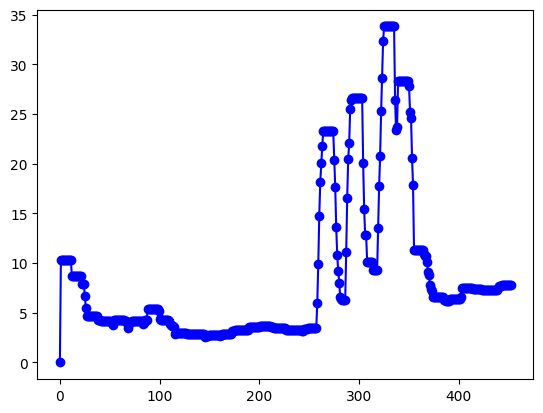

Score:  2578.0
<|im_start|>user
 & \cellcolor{red!10}55.62 & \cellcolor{red!10}52.65 \\

& \cellcolor{red!10}~~~H2O: 4096 & \cellcolor{red!10}22.61 & \cellcolor{red!10}29.06 & \cellcolor{red!10}47.22 & \cellcolor{red!10}36.54 & \cellcolor{red!10}20.6 & \cellcolor{red!10}16.25 & \cellcolor{red!10}30.0 & \cellcolor{red!10}23.8 & \cellcolor{red!10}26.75 & \cellcolor{red!10}70.5 & \cellcolor{red!10}86.16 & \cellcolor{red!10}42.97 & \cellcolor{red!10}\textbf{3.46} & \cellcolor{red!10}86.38 & \cellcolor{red!10}53.72 & \cellcolor{red!10}51.1 \\

\specialrule{1pt}{2pt}{10pt}\specialrule{1pt}{2pt}{2pt}


\multirow{5}{*}{\rotatebox[origin=c]{90}{\fontsize{18}{100}\selectfont Mixtral}}

& \cellcolor{cyan!10}~~~All KV & \cellcolor{cyan!10}{26.81} & \cellcolor{cyan!10}\textbf{37.06} & \cellcolor{cyan!10}51.55 & \cellcolor{cyan!10}47.77 & \cellcolor{cyan!10}32.46 & \cellcolor{cyan!10}\textbf{26.59} & \cellcolor{cyan!10}\textbf{34.25} & \cellcolor{cyan!10}\textbf{26.05} & \cellcolor{cyan!10}27.91 & \

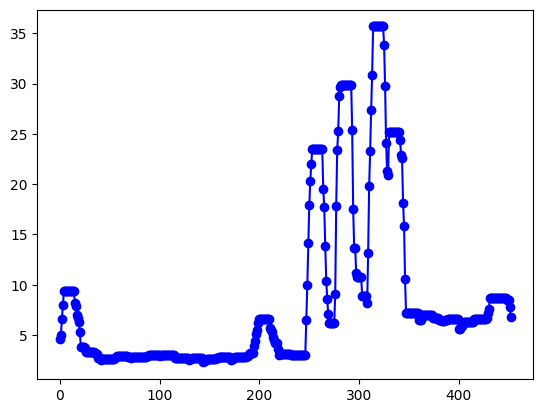

Score:  2420.0
<|im_start|>user
specialrule{1pt}{2pt}{2pt}

\multirow{5}{*}{\rotatebox[origin=c]{90}{\fontsize{18}{100}\selectfont LongChat}}

& \cellcolor{blue!10}~~~All KV & \cellcolor{blue!10}\textbf{20.88} & \cellcolor{blue!10}\textbf{29.36} & \cellcolor{blue!10}\textbf{43.2} & \cellcolor{blue!10}33.05 & \cellcolor{blue!10}24.58 & \cellcolor{blue!10}\textbf{14.66} & \cellcolor{blue!10}\textbf{30.89} & \cellcolor{blue!10}22.76 & \cellcolor{blue!10}\textbf{26.61} & \cellcolor{blue!10}\textbf{66.5} & \cellcolor{blue!10}\textbf{83.99} & \cellcolor{blue!10}\textbf{40.83} & \cellcolor{blue!10}0.0 & \cellcolor{blue!10}30.5 & \cellcolor{blue!10}54.89 & \cellcolor{blue!10}\textbf{59.05} \\
\cline{2-18}

& \cellcolor{blue!10}~~~\kv: 1024 & \cellcolor{blue!10}19.32 & \cellcolor{blue!10}26.6 & \cellcolor{blue!10}37.93 & \cellcolor{blue!10}34.15 & \cellcolor{blue!10}23.34 & \cellcolor{blue!10}12.71 & \cellcolor{blue!10}23.45 & \cellcolor{blue!10}21.81 & \cellcolor{blue!10}24.93 & \cellcolor{blu

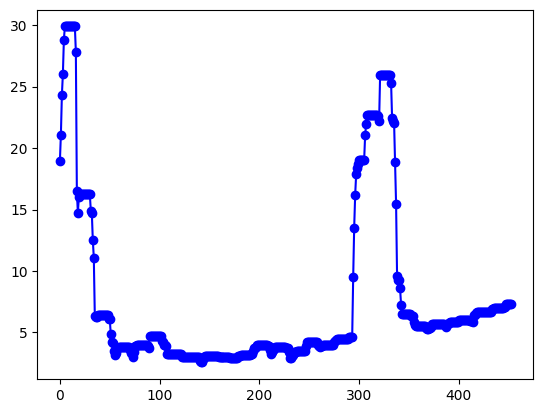

Score:  2410.0
<|im_start|>user
red!10}40.94 & \cellcolor{red!10}25.7 & \cellcolor{red!10}\textbf{19.42} & \cellcolor{red!10}25.89 & \cellcolor{red!10}23.82 & \cellcolor{red!10}26.11 & \cellcolor{red!10}69.5 & \cellcolor{red!10}\textbf{86.48} & \cellcolor{red!10}42.06 & \cellcolor{red!10}2.98 & \cellcolor{red!10}\textbf{88.56} & \cellcolor{red!10}55.65 & \cellcolor{red!10}51.87 \\


& \cellcolor{red!10}~~~\kv: 2048 & \cellcolor{red!10}25.89 & \cellcolor{red!10}32.47 & \cellcolor{red!10}48.6 & \cellcolor{red!10}41.71 & \cellcolor{red!10}27.31 & \cellcolor{red!10}18.69 & \cellcolor{red!10}28.81 & \cellcolor{red!10}\textbf{24.5} & \cellcolor{red!10}26.6 & \cellcolor{red!10}70.0 & \cellcolor{red!10}86.27 & \cellcolor{red!10}42.47 & \cellcolor{red!10}3.09 & \cellcolor{red!10}87.43 & \cellcolor{red!10}\textbf{55.93} & \cellcolor{red!10}52.01 \\


& \cellcolor{red!10}~~~\kv: 4096 & \cellcolor{red!10}26.41 & \cellcolor{red!10}\textbf{33.36} & \cellcolor{red!10}\textbf{49.81} & \cellcolor{red!1

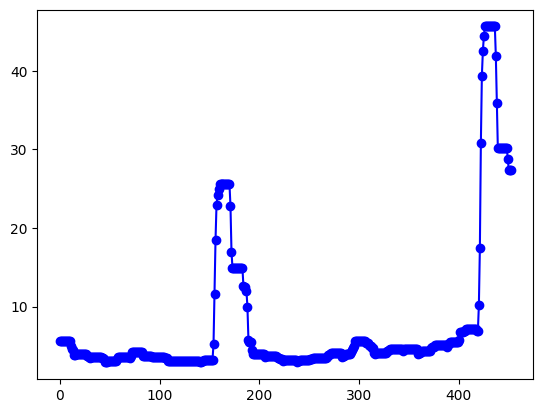

Score:  2396.0
<|im_start|>user
6 & \cellcolor{green!10}24.22 &\cellcolor{green!10} 24.36 &\cellcolor{green!10} 70.0 &\cellcolor{green!10} 61.11 & \cellcolor{green!10} 39.91 &\cellcolor{green!10} 2.17 &\cellcolor{green!10}4.0 & \cellcolor{green!10}44.46 & \cellcolor{green!10}\textbf{44.92}\\


&\cellcolor{green!10}~~~\kv: 4096 & \cellcolor{green!10}17.92&\cellcolor{green!10}25.47 &\cellcolor{green!10} 40.76 &\cellcolor{green!10} \textbf{24.92} &\cellcolor{green!10} 19.53&\cellcolor{green!10} 11.27 &\cellcolor{green!10} 25.34 & \cellcolor{green!10}\textbf{25.42} &\cellcolor{green!10} 24.58 &\cellcolor{green!10} 70.5 &\cellcolor{green!10} 61.08 & \cellcolor{green!10} 39.62 &\cellcolor{green!10} \textbf{3.17} &\cellcolor{green!10}\textbf{4.0} & \cellcolor{green!10}\textbf{44.49} & \cellcolor{green!10}44.08\\

&\cellcolor{green!10}~~~H2O: 4096 & \cellcolor{green!10}13.17&\cellcolor{green!10}24.82&\cellcolor{green!10}20.01&\cellcolor{green!10} 16.86 &\cellcolor{green!10} 9.74&\cellcolor{gre

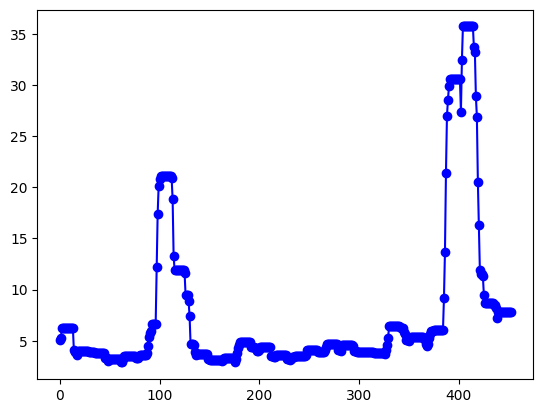

Score:  2338.0
<|im_start|>user
0}5.5 & \cellcolor{cyan!10}100.0 & \cellcolor{cyan!10}68.72 & \cellcolor{cyan!10}\textbf{70.01} \\

& \cellcolor{cyan!10}~~~\kv: 4096 & \cellcolor{cyan!10}26.46 & \cellcolor{cyan!10}37.03 & \cellcolor{cyan!10}\textbf{52.62} & \cellcolor{cyan!10}47.71 & \cellcolor{cyan!10}\textbf{33.35} & \cellcolor{cyan!10}26.45 & \cellcolor{cyan!10}32.64 & \cellcolor{cyan!10}25.87 & \cellcolor{cyan!10}\textbf{27.94} & \cellcolor{cyan!10}75.5 & \cellcolor{cyan!10}\textbf{90.71} & \cellcolor{cyan!10}\textbf{47.14} & \cellcolor{cyan!10}5.5 & \cellcolor{cyan!10}\textbf{100.0} & \cellcolor{cyan!10}68.81 & \cellcolor{cyan!10}69.56 \\

& \cellcolor{cyan!10}~~~H2O: 4096 & \cellcolor{cyan!10}20.45 & \cellcolor{cyan!10}32.09 & \cellcolor{cyan!10}48.02 & \cellcolor{cyan!10}34.76 & \cellcolor{cyan!10}25.69 & \cellcolor{cyan!10}16.5 & \cellcolor{cyan!10}29.76 & \cellcolor{cyan!10}23.53 & \cellcolor{cyan!10}26.84 & \cellcolor{cyan!10}74.5 & \cellcolor{cyan!10} approaches on managing 

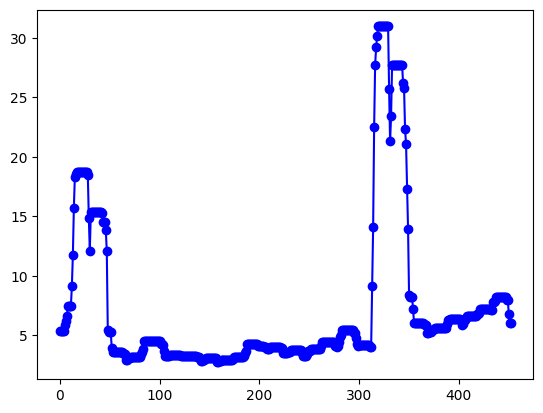

Score:  2318.0
<|im_start|>user
cellcolor{red!10}70.0 & \cellcolor{red!10}86.27 & \cellcolor{red!10}42.47 & \cellcolor{red!10}3.09 & \cellcolor{red!10}87.43 & \cellcolor{red!10}\textbf{55.93} & \cellcolor{red!10}52.01 \\


& \cellcolor{red!10}~~~\kv: 4096 & \cellcolor{red!10}26.41 & \cellcolor{red!10}\textbf{33.36} & \cellcolor{red!10}\textbf{49.81} & \cellcolor{red!10}42.32 & \cellcolor{red!10}\textbf{27.93} & \cellcolor{red!10}18.76 & \cellcolor{red!10}30.74 & \cellcolor{red!10}24.19 & \cellcolor{red!10}\textbf{27.08} & \cellcolor{red!10}\textbf{71.0} & \cellcolor{red!10}86.25 & \cellcolor{red!10}\textbf{43.01} & \cellcolor{red!10}2.73 & \cellcolor{red!10}86.18 & \cellcolor{red!10}55.62 & \cellcolor{red!10}52.65 \\

& \cellcolor{red!10}~~~H2O: 4096 & \cellcolor{red!10}22.61 & \cellcolor{red!10}29.06 & \cellcolor{red!10}47.22 & \cellcolor{red!10}36.54 & \cellcolor{red!10}20.6 & \cellcolor{red!10}16.25 & \cellcolor{red!10}30.0 & \cellcolor{red!10}23.8 & \cellcolor{red!10}26.75 & \cellc

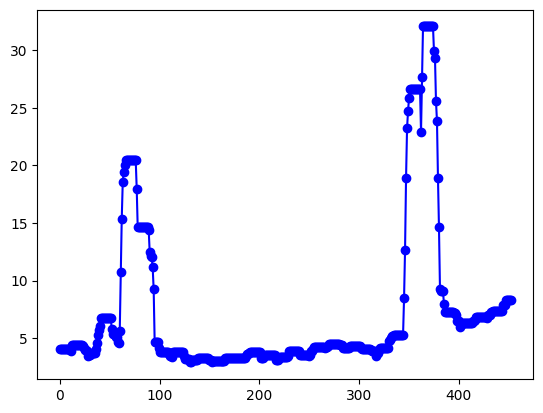

Score:  2300.0
<|im_start|>user
.44 & \cellcolor{blue!10}26.3 & \cellcolor{blue!10}22.29 & \cellcolor{blue!10}25.73 & \cellcolor{blue!10}66.0 & \cellcolor{blue!10}79.93 & \cellcolor{blue!10}39.59 & \cellcolor{blue!10}0.0 & \cellcolor{blue!10}\textbf{31.0} & \cellcolor{blue!10}\textbf{56.05} & \cellcolor{blue!10}58.61 \\

& \cellcolor{blue!10}~~~\kv: 4096 & \cellcolor{blue!10}20.68 & \cellcolor{blue!10}29.34 & \cellcolor{blue!10}42.21 & \cellcolor{blue!10}33.95 & \cellcolor{blue!10}\textbf{24.88} & \cellcolor{blue!10}14.15& \cellcolor{blue!10}28.55 & \cellcolor{blue!10}\textbf{23.11} & \cellcolor{blue!10}26.45 & \cellcolor{blue!10}66.0 & \cellcolor{blue!10}\textbf{81.25} & \cellcolor{blue!10}\textbf{40.52} & \cellcolor{blue!10}0.0 & \cellcolor{blue!10}29.5 & \cellcolor{blue!10}54.79 & \cellcolor{blue!10}58.81 \\

& \cellcolor{blue!10}~~~H2O: 4096 & \cellcolor{blue!10}19.31 & \cellcolor{blue!10}28.3 & \cellcolor{blue!10}37.75 & \cellcolor{blue!10}30.51&\cellcolor{green!10} \textbf{61.42}

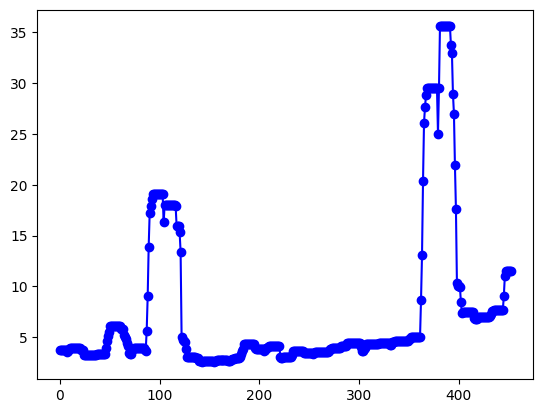

Score:  2244.0
<|im_start|>user
 \cellcolor{cyan!10}~~~All KV & \cellcolor{cyan!10}{26.81} & \cellcolor{cyan!10}\textbf{37.06} & \cellcolor{cyan!10}51.55 & \cellcolor{cyan!10}47.77 & \cellcolor{cyan!10}32.46 & \cellcolor{cyan!10}\textbf{26.59} & \cellcolor{cyan!10}\textbf{34.25} & \cellcolor{cyan!10}\textbf{26.05} & \cellcolor{cyan!10}27.91 & \cellcolor{cyan!10}76.0 & \cellcolor{cyan!10}90.57 & \cellcolor{cyan!10}46.98 & \cellcolor{cyan!10}5.5 & \cellcolor{cyan!10}100.0 & \cellcolor{cyan!10}\textbf{69.07} & \cellcolor{cyan!10}69.65 \\
\cline{2-18}

& \cellcolor{cyan!10}~~~\kv: 1024 & \cellcolor{cyan!10}26.01 & \cellcolor{cyan!10}34.65 & \cellcolor{cyan!10}51.58 & \cellcolor{cyan!10}\textbf{48.23} & \cellcolor{cyan!10}32.67 & \cellcolor{cyan!10}25.92 & \cellcolor{cyan!10}27.77 & \cellcolor{cyan!10}25.0 & \cellcolor{cyan!10}27.25 & \cellcolor{cyan!10}74.5 & \cellcolor{cyan!10}90.42 & \cellcolor{cyan!10}46.48 & \cellcolor{cyan!10}5.5 & \cellcolor{cyan!10}99.5 & \cellcolor{cyan!10}69.02 & 

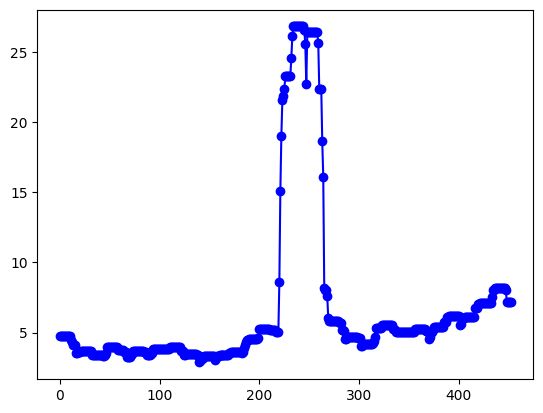

Score:  2086.0
<|im_start|>user
0}\selectfont Mistral}}

& \cellcolor{red!10}~~~All KV & \cellcolor{red!10}\textbf{26.82} & \cellcolor{red!10}33.06 & \cellcolor{red!10}49.28 & \cellcolor{red!10}\textbf{42.77} & \cellcolor{red!10}27.33 & \cellcolor{red!10}19.27 & \cellcolor{red!10}\textbf{32.85} & \cellcolor{red!10}24.25 & \cellcolor{red!10}27.06 & \cellcolor{red!10}71.0 & \cellcolor{red!10}86.23 & \cellcolor{red!10}42.98 & \cellcolor{red!10}2.75 & \cellcolor{red!10}86.98 & \cellcolor{red!10}55.51 & \cellcolor{red!10}\textbf{52.88} \\
\cline{2-18}

& \cellcolor{red!10}~~~\kv: 1024 & \cellcolor{red!10}25.54 & \cellcolor{red!10}29.51 & \cellcolor{red!10}49.25 & \cellcolor{red!10}40.94 & \cellcolor{red!10}25.7 & \cellcolor{red!10}\textbf{19.42} & \cellcolor{red!10}25.89 & \cellcolor{red!10}23.82 & \cellcolor{red!10}26.11 & \cellcolor{red!10}69.5 & \cellcolor{red!10}\textbf{86.48} & \cellcolor{red!10}42.06 & \cellcolor{red!10}2.98 & \cellcolor{red!10}\textbf{88.56} & \cellcolor{red!10}55.65

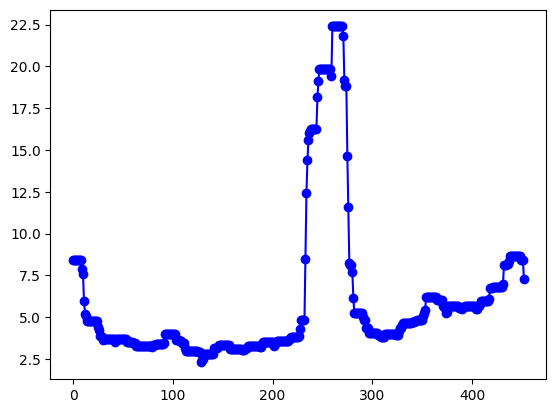

Score:  2050.0
<|im_start|>user
58.81 \\

& \cellcolor{blue!10}~~~H2O: 4096 & \cellcolor{blue!10}19.31 & \cellcolor{blue!10}28.3 & \cellcolor{blue!10}37.75 & \cellcolor{blue!10}30.51&\cellcolor{green!10} \textbf{61.42} & \cellcolor{green!10} 39.64 &\cellcolor{green!10} 1.67 &\cellcolor{green!10}3.0 & \cellcolor{green!10}43.34 & \cellcolor{green!10}44.0\\



&\cellcolor{green!10}~~~\kv: 2048 & \cellcolor{green!10}17.92&\cellcolor{green!10}25.03&\cellcolor{green!10} \textbf{41.38} &\cellcolor{green!10} 24.49 &\cellcolor{green!10} 19.38&\cellcolor{green!10} \textbf{11.34} &\cellcolor{green!10} 21.6 & \cellcolor{green!10}24.22 &\cellcolor{green!10} 24.36 &\cellcolor{green!10} 70.0 &\cellcolor{green!10} 61.11 & \cellcolor{green!10} 39.91 &\cellcolor{green!10} 2.17 &\cellcolor{green!10}4.0 & \cellcolor{green!10}44.46 & \cellcolor{green!10}\textbf{44.92}\\


&\cellcolor{green!10}~~~\kv: 4096 & \cellcolor{green!10}17.92&\cellcolor{green!10}25. approaches on managing the challenges of large-sca

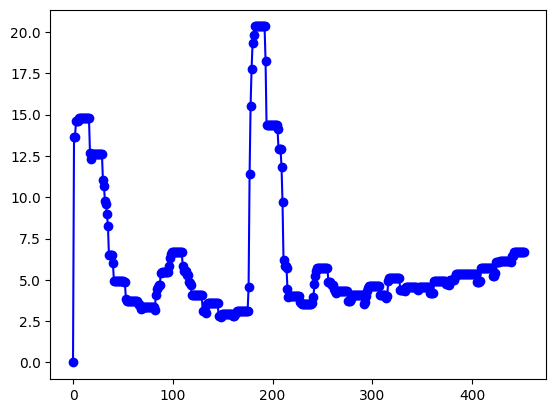

Score:  1756.0
<|im_start|>user
}~~~\kv: 1024 & \cellcolor{blue!10}19.32 & \cellcolor{blue!10}26.6 & \cellcolor{blue!10}37.93 & \cellcolor{blue!10}34.15 & \cellcolor{blue!10}23.34 & \cellcolor{blue!10}12.71 & \cellcolor{blue!10}23.45 & \cellcolor{blue!10}21.81 & \cellcolor{blue!10}24.93 & \cellcolor{blue!10}65.0 & \cellcolor{blue!10}80.88 & \cellcolor{blue!10}38.19 & \cellcolor{blue!10}0.0 & \cellcolor{blue!10}31.0 & \cellcolor{blue!10}53.63 & \cellcolor{blue!10}57.62 \\

& \cellcolor{blue!10}~~~\kv: 2048 & \cellcolor{blue!10}19.28 & \cellcolor{blue!10}28.81 & \cellcolor{blue!10}40.26 & \cellcolor{blue!10}\textbf{35.31} & \cellcolor{blue!10}23.75 & \cellcolor{blue!10}13.44 & \cellcolor{blue!10}26.3 & \cellcolor{blue!10}22.29 & \cellcolor{blue!10}25.73 & \cellcolor{blue!10}66.0 & \cellcolor{blue!10}79.93 & \cellcolor{blue!10}39.59 & \cellcolor{blue!10}0.0 & \cellcolor{blue!10}\textbf{31.0} & \cellcolor{blue!10}\textbf{56.05} & \cellcolor{blue!10}58.61 \\

& \cellcolor{blue!10}~~~\kv: 40

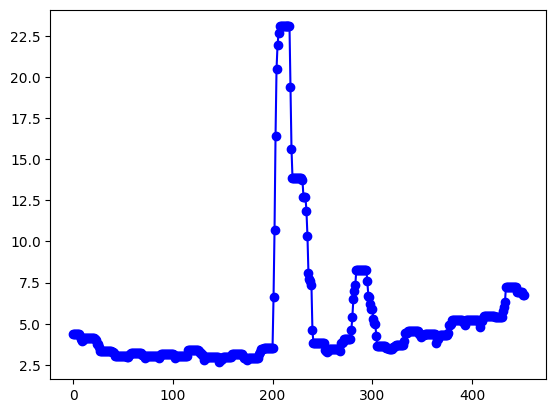

Score:  1256.0
<|im_start|>user
1pt}{2pt}{2pt}

\multirow{5}{*}{\rotatebox[origin=c]{90}{\fontsize{18}{100}\selectfont LWMChat}}

&\cellcolor{green!10}~~~All KV & \cellcolor{green!10}\textbf{18.18}&\cellcolor{green!10}\textbf{25.56}&\cellcolor{green!10} 40.94 &\cellcolor{green!10} 24.57 &\cellcolor{green!10} 19.39&\cellcolor{green!10} 10.49 &\cellcolor{green!10} \textbf{27.97} & \cellcolor{green!10}24.9 &\cellcolor{green!10} \textbf{24.81} &\cellcolor{green!10}71.0&\cellcolor{green!10} 60.9 & \cellcolor{green!10} 39.73 &\cellcolor{green!10} 3.17 &\cellcolor{green!10}3.5 & \cellcolor{green!10}44.4 & \cellcolor{green!10}43.82\\
\cline{2-18}

&\cellcolor{green!10}~~~\kv: 1024 & \cellcolor{green!10}18.02&\cellcolor{green!10}23.73&\cellcolor{green!10} 40.25 &\cellcolor{green!10} 24.61 &\cellcolor{green!10} \textbf{19.84}&\cellcolor{green!10} 10.77 &\cellcolor{green!10} 19.79 & \cellcolor{green!10}24.44 &\cellcolor{green!10} 23.53 &\cellcolor{green!10} 70.0"\texttt{line makeshift-penguin: RE

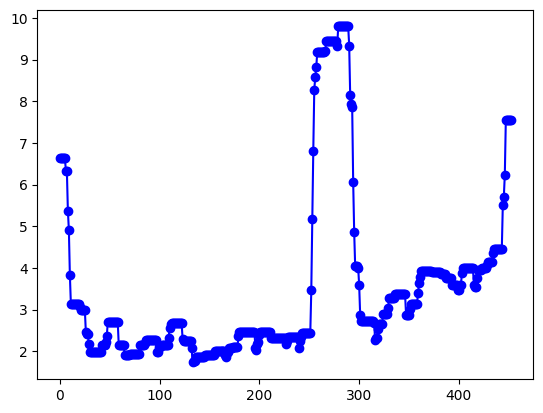

In [16]:
import matplotlib.pyplot as plt
import numpy as np

content_tokens = encoded_tokens[:-query_window]
query_tokens = encoded_tokens[-query_window:]
unpadded_chunks = []
print("Query tokens: ", tokenizer.decode(query_tokens))

content = tokenizer.decode(content_tokens)

for chunk in chunk_text_naturally(content):
    content_tokens = tokenizer(chunk, return_tensors="pt")
    for key in content_tokens:
        content_tokens[key] = content_tokens[key].cuda()
    content_tokens = content_tokens.input_ids[0]    

    total_length = content_tokens.shape[-1] - query_window
    x = padding_window
    y = max_tokens - padding_window * 2 - query_window

    for content_start in range(0, total_length - y, y):
        split_start = max(0, content_start - x)
        split_end = min(content_start + y, total_length)
        # Adjust post-chunk and pre-chunk if necessary
        post_chunk_end = min(split_end + x, total_length)
        pre_chunk_start = max(0, split_start - x)

        # Handle wrapping for pre-chunk
        if split_start - x < 0:
            pre_chunk_start = total_length + (split_start - x)
            pre_chunk = torch.cat((content_tokens[pre_chunk_start:], content_tokens[:split_start]), dim=-1)
        else:
            pre_chunk = content_tokens[pre_chunk_start:split_start]

        # Handle wrapping for post-chunk
        if split_end + x > total_length:
            post_chunk_end = (split_end + x) % total_length
            post_chunk = torch.cat((content_tokens[split_end:], content_tokens[:post_chunk_end]), dim=-1)
        else:
            post_chunk = content_tokens[split_end:post_chunk_end]

        # Combine pre-chunk, relevant content, and post-chunk
        chunk_tensor = torch.cat((pre_chunk, content_tokens[split_start:split_end], post_chunk, query_tokens), dim=-1)
        decoded_tokens = tokenizer.decode(chunk_tensor, skip_special_tokens=True)
        chunk_text = tokenizer.apply_chat_template([{
            "role": "user",
            "content": decoded_tokens
        }], tokenize=False)

        unpadded_chunks.append(chunk_text)

    print("Unpadded chunks length: ", len(unpadded_chunks))

tokenizer.pad_token = tokenizer.eos_token
chunks = tokenizer(unpadded_chunks, return_tensors="pt", padding=True)

unpadded_chunks_start = []
for chunk in chunks['input_ids']:
    index = 0
    while index < chunk.shape[-1] and chunk[index] == tokenizer.pad_token:
        index += 1
    unpadded_chunks_start.append(index)

print("Unpadded chunks start: ", unpadded_chunks_start)

for key in chunks:
    chunks[key] = chunks[key].to(model.device)

outputs = model.generate(**chunks, output_attentions=True, return_dict_in_generate=True, max_new_tokens=1)
attention_scores = outputs.attentions[0]

print("First length: ", len(attention_scores))
print("Second length: ", len(attention_scores[0]))
print("Third length: ", attention_scores[0][0].shape)
# print(attention_scores)

# since we have each of these in distinct layers, we should first stack them
attention_scores = torch.stack(attention_scores, dim=0)
print("Shape: ", attention_scores.shape)
attention_scores = attention_scores.sum(dim=0)
print("Shape: ", attention_scores.shape)
attention_scores = attention_scores.squeeze(0)
print("Shape: ", attention_scores.shape)

chunk_scores = []
attention_weights = []

for chunk_text, chunk_start, scores in zip(unpadded_chunks, unpadded_chunks_start, attention_scores):
    intermediate_sum = torch.sum(scores[:, chunk_start + padding_window:-padding_window], dim=0)
    intermediate_sum = torch.where(intermediate_sum < 100, intermediate_sum, torch.tensor(0))
    interest_score = torch.sum(intermediate_sum)
    chunk_scores.append((interest_score.cpu().numpy(), chunk_text, intermediate_sum.cpu().numpy()))

def apply_max_attentions(tensor: np.ndarray, length=5):
    indices = np.argsort(tensor)
    values = tensor[indices]

    new_tensor = np.zeros(tensor.shape)
    
    for value, index in zip(values, indices): # going from low to high
        left_index = max(0, index - length)
        right_index = min(tensor.shape[-1] - 1, index + length)
        new_tensor[left_index:right_index + 1] = value

    return new_tensor

chunk_scores = sorted(chunk_scores, reverse=True)

for score, text, attention_scores in chunk_scores:
    print("Score: ", score)
    print(text)
    attention_scores = apply_max_attentions(attention_scores)
    plt.plot(range(attention_scores.shape[-1]), attention_scores, marker='o', linestyle='-', color='b')
    plt.show()
    # print("Attention scores: ", attention_scores)
    print("===================")